In [1]:
import math 
import numpy as np
import pylab as plt
import astropy.units as u
import astropy.constants as Con
import matplotlib as mpl
from scipy.optimize import fmin
from multiprocessing import Pool
from scipy.signal import find_peaks
#import emcee
import numba
%matplotlib inline

In [2]:
plt.style.use(['science', 'ieee', 'high-vis'])
mpl.rcParams['figure.dpi'] = 300
mpl.rc('pdf', fonttype=42)

## data

In [3]:
mjd_GBT = np.array([59106.79, 59292.45, 59300.47, 59522.71, 59522.69])
rm_GBT = np.array([-6700, 3700, 2100, -24010, -23500])*(1+0.241)**2


In [4]:
mjd_Parkes = np.array([59373.6101602727,59373.6119604420,59373.6527697290,59384.6333777010,
                        59400.4348331362,59400.4786563295,59588.8344457013,59588.9067463214])
rm_Parkes = np.array([12956,12556,11756,8054,10135,9715,-15518,-16358])*(1+0.241)**2
mjd = np.r_[mjd_GBT,mjd_Parkes]
rm = np.r_[rm_GBT,rm_Parkes]
rmf = rm 

In [5]:
rm.mean()

-1790.5218641538465

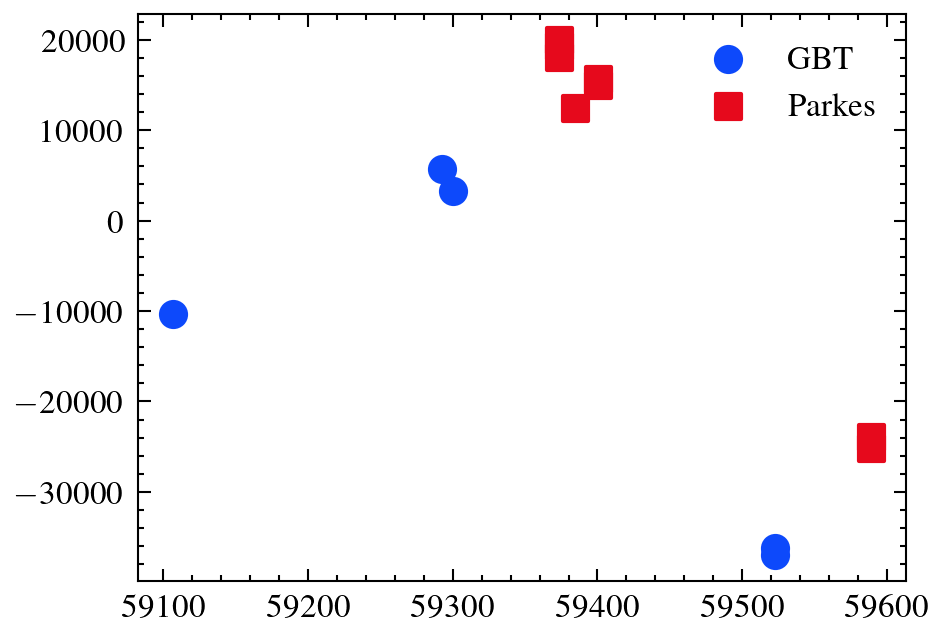

In [6]:
plt.scatter(mjd_GBT, rm_GBT,marker='o',label="GBT")
plt.scatter(mjd_Parkes, rm_Parkes,marker='s',label="Parkes")
plt.legend()

In [7]:
class BeStar():
    '''The Be star model'''
    def __init__(self, Rstar, M_star):
        '''Initial parameters
            params:
                Rstar  : The radius of Be stars (unit: Solar Radius)
                M_star : The mass of Be stars (units: Solar Mass)'''
        self.Rstar = Rstar
        self.M_star = M_star


class powerDisk():
    '''The power-law disk model'''
    def __init__(self, star, rho0, cs, n, radius = 0):
        '''Initial parameters
            params:
                star   : The Be star model
                rho0   : The base density (cgs units)
                cs     : The isothermal sound speed (cgs units)
                n      : The power-law index, expect 2-5'''
        self.star = star
        self.rho0 = rho0
        self.cs = cs
        self.n = n
        self.rhoC = 0
        if (radius):
            self.radius = radius
            self.rhoC = self.rho0 * (radius / self.star.Rstar) ** (-self.n)
        else:
            self.radius = 0
            
        
    def Hr(self, r):
        r = (r * 6.955e8 * u.m).cgs
        results = self.cs * (u.cm / u.s) * np.sqrt(r / (self.star.M_star * Con.M_sun).cgs / Con.G.cgs) * r
        return ((results) / Con.R_sun).cgs
        
    def rho(self, coor):
        r = np.sqrt(coor[:, 0] ** 2 + coor[:, 1] ** 2 + coor[:, 2] ** 2)
        z = coor[:, 2]
        result = self.rho0 * (r / self.star.Rstar) ** (- self.n) * np.exp(- (z / self.Hr(r)) ** 2)
        if (self.radius):
            idx = (result < self.rhoC)
            result[idx] = 0
        idx = (result > self.rho0)
        result[idx] = 0
        return result
    
class windDisk():
    '''The power-law disk model'''
    def __init__(self, star, rho0, n):
        '''Initial parameters
            params:
                star   : The Be star model
                rho0   : The base density (cgs units)
                cs     : The isothermal sound speed (cgs units)
                n      : The power-law index, expect 2-5'''
        self.star = star
        self.rho0 = rho0
        self.n = n
        
    def rho(self, coor):
        r = np.sqrt(coor[:, 0] ** 2 + coor[:, 1] ** 2 + coor[:, 2] ** 2)
        return self.rho0 * (r / self.star.Rstar) ** (- self.n) 
    
    
class magModel():
    '''The magnetar model'''
    def __init__(self, star, B0):
        '''Initial parameters
            params:
                star : The Be star model
                B0   : The base magnetar field (cgs units, G)'''
        self.star = star
        self.B0 = B0
    
    def mag(self, coor):
        r = np.linalg.norm(coor, axis = 1)
        return self.B0 * (coor / self.star.Rstar)  / r.reshape(-1, 1) ** 2

In [8]:
def deriveRM(coor, disk, B, v, length, ratio):
    '''This function derive the RM.
         params:
            coor  : the coordinates of source (units: Solar Radius)
            disk  : the disk model
            B     : the magnetar field model
            v     : the direction vector
            length: the integration length (unit: Solar Radius)'''
    intNum = 1000
    intArr = np.linspace(0, length, intNum)
    samplePoint = coor + intArr.reshape([-1, 1]) * v
    rho = disk.rho(samplePoint)
    n0 = rho / Con.m_p.cgs.value
    ne = (np.sqrt(ratio ** 2 + 4 * ratio * n0) - ratio) / 2
    parB = np.sum(B.mag(samplePoint) * v, axis = 1)
    rm = 8.1e5 * parB * ne
    return (rm.sum() * length / intNum * Con.R_sun).to(u.pc).value

def deriveDM(coor, disk, v, length, ratio):
    '''This function derive the RM.
         params:
            coor  : the coordinates of source (units: Solar Radius)
            disk  : the disk model
            B     : the magnetar field model
            v     : the direction vector
            length: the integration length (unit: Solar Radius)'''
    intNum = 1000
    intArr = np.linspace(0, length, intNum)
    samplePoint = coor + intArr.reshape([-1, 1]) * v
    rho = disk.rho(samplePoint)
    n0 = rho / Con.m_p.cgs.value
    ne = (np.sqrt(ratio ** 2 + 4 * ratio * n0) - ratio) / 2
    return (ne.sum() * length / intNum * Con.R_sun).to(u.pc).value

def deriveTau(coor, disk, v, length, ratio, T, vfre):
    '''This function derive the RM.
         params:
            coor  : the coordinates of source (units: Solar Radius)
            disk  : the disk model
            B     : the magnetar field model
            v     : the direction vector
            length: the integration length (unit: Solar Radius)'''
    intNum = 1000
    intArr = np.linspace(0, length, intNum)
    samplePoint = coor + intArr.reshape([-1, 1]) * v
    rho = disk.rho(samplePoint)
    n0 = rho / Con.m_p.cgs.value
    ne = (np.sqrt(ratio ** 2 + 4 * ratio * n0) - ratio) / 2
    return 8.2e-2 * T ** -1.35 * vfre ** -2.1 * ((ne ** 2).sum() * length / intNum * Con.R_sun).to(u.pc).value

In [9]:
T = 2e4 * u.K
lame = np.sqrt(Con.h ** 2 / 2 / np.pi / Con.m_e / Con.k_B / T)
varep = 13.6 * u.eV
ratio = 2 / lame ** 3 * np.exp(- varep / Con.k_B / T)
ratio = ratio.cgs.value

In [10]:
# Kelper third law
mbe = 30
mns = 1.4
porb = 600
a = (Con.G * (mbe + mns) * Con.M_sun * (porb  * u.day) ** 2 / 4 / math.pi ** 2) ** (1/3) 

In [11]:
star = BeStar(Rstar = 10, M_star = 30)
# sound speed, we adopt T = 2e4 K, mu = 1
cs = np.sqrt(Con.k_B * T / 1 / Con.m_p).cgs.value
disk = powerDisk(star, rho0 = 5e-12, cs = cs, n = 3)
magn = magModel(star, B0 = 10)
theta = np.linspace(0, 2 * np.pi, 1000)
thetaoff = -0.8*np.pi 
theta = theta + thetaoff
e = 0.75
p = a * (1 - e ** 2)
r = p.to(u.solRad).value / (1 + e * np.cos(theta))
phi = 0

In [12]:
# v = np.array([0.95, -0.27, -0.14])
# v = v / np.linalg.norm(v)
ang1 = 0.18#0.2
ang2 = 2 #2
v = np.array([np.sin(ang1) * np.cos(ang2), np.sin(ang1) * np.sin(ang2), np.cos(ang1)])
v = v / np.linalg.norm(v)
rm = []
dm = []
tau = []
for i in range(1000):
    coor = np.array([r[i] * np.cos(theta[i]), r[i] * np.sin(theta[i]) * np.cos(phi), r[i] * np.sin(theta[i]) * np.sin(phi)])
    rm.append(deriveRM(coor, disk, magn, v, 1000, ratio))
    dm.append(deriveDM(coor, disk, v, 2000, ratio))
    tau.append(deriveTau(coor, disk, v, 2000, ratio, T.value, 1.25))

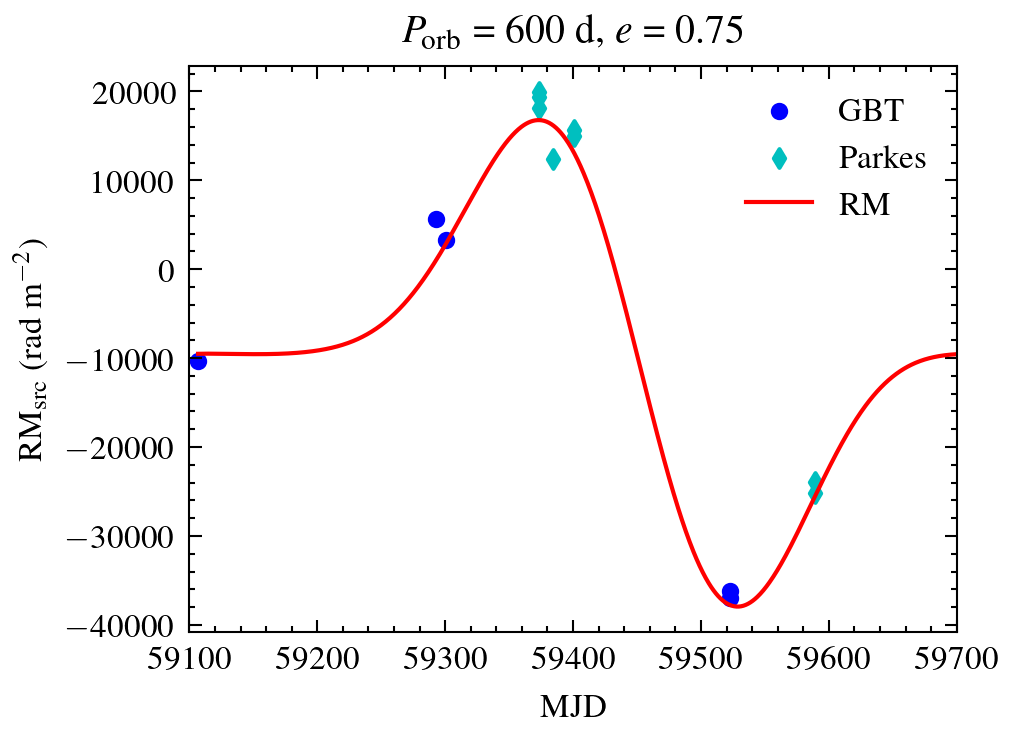

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)
mjdf = (( 2 * np.pi - (theta - thetaoff))) / (2 * np.pi) * porb + mjd.min()
RM0 = -10000
plt.scatter(mjd_GBT, rm_GBT, color = 'b', s = 10,label='GBT')
plt.scatter(mjd_Parkes, rm_Parkes, color = 'c',marker='d',s = 10,label='Parkes')
plt.plot(mjdf, np.array(rm)+RM0, 'r', label = 'RM')
thetaf = (mjd - mjd.min()) / porb * 2 * np.pi
# plt.fill_between(reduceMJD, reduceRMmax, reduceRMmin, alpha = 0.5)
# plt.scatter(mjd, rmf, s = 1)
#plt.hlines(RM0,59100,59700,linestyles='--',colors='grey',label=r'RM$_{0}$')
plt.xlabel(r'MJD')
plt.ylabel(r'RM$_{\mathrm{src}}$ (rad m$^{-2}$)')
plt.title(r'$P_{\mathrm{orb}}$ = 600 d, $e$ = 0.75')
plt.legend()
plt.xlim(59100,59700)
plt.savefig('RM190520B.pdf',bbox_inches = 'tight')

In [14]:
# def plotBat(ang1, ang2):
#             v = np.array([np.sin(ang1) * np.cos(ang2), np.sin(ang1) * np.sin(ang2), np.cos(ang1)])
#             v = v / np.linalg.norm(v)
#             rm = []
#             for i in range(1000):
#                 coor = np.array([r[i] * np.cos(theta[i]), r[i] * np.sin(theta[i]) * np.cos(phi), r[i] * np.sin(theta[i]) * np.sin(phi)])
#                 rm.append(deriveRM(coor, disk, magn, v, 1000, ratio))
#             rm = np.array(rm)
#             pN = find_peaks(rm, distance = 90, height = np.mean(rm), prominence = 5)[0].shape[0]
#             if (np.abs(rm).max() > 0):
#                 ditch = (rm.max() - rm.min()) / np.abs(rm).max()            
#                 if ((pN > 1) and ditch > 1.1):
#                     plt.figure()
#                     plt.plot(theta, rm)
#                     plt.savefig('TestFigure/tmp_p_700_phi_pi_80_e_08_n_4_ang1_{:.2f}_ang2_{:.2f}.jpg'.format(ang1, ang2))  
#                     plt.close()

# tmp = []
# thetaarr = np.linspace(0, np.pi , 50)
# phiarr = np.linspace(0, 2 * np.pi, 50)
# for i in thetaarr:
#     for j in phiarr:
#         tmp.append([i, j])
            
# with Pool() as pool:
#     pool.starmap(plotBat, tmp)